# <span style="color:#0b486b">SIT 112 - Data Science Concepts</span>

---
Lecturer: Truyen Tran | truyen.tran@deakin.edu.au<br />


School of Information Technology, <br />
Deakin University, VIC 3215, Australia.

---
## <span style="color:#0b486b">Practical Session 7: K-Means Clustering with Scikit-Learn</span>

**The purpose of this session is to teach you about:**

1. Scikit-Learn Package
2. K-Means Clustering

---
## <span style="color:#0b486b">1. Scikit-Learn</span>



[Scikit-Learn](http://github.com/scikit-learn/scikit-learn) is a Python package designed to give access to **well-known** machine learning algorithms within Python code, through a **clean, well-thought-out API**. It has been built by hundreds of contributors from around the world, and is used across industry and academia.

Scikit-Learn is built upon Python's [NumPy (Numerical Python)](http://numpy.org) and [SciPy (Scientific Python)](http://scipy.org) libraries, which enable efficient in-core numerical and scientific computation within Python. As such, scikit-learn is not specifically designed for extremely large datasets, though there is [some work](https://github.com/ogrisel/parallel_ml_tutorial) in this area.

### <span style="color:#0b486b">1.1 Representation of Data in Scikit-learn</span>

Machine learning is about creating models from data: for that reason, we'll start by
discussing how data can be represented in order to be understood by the computer.  Along
with this, we'll build on our matplotlib examples from the previous section and show some
examples of how to visualize data.

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each
  item in a quantitative manner.  Features are generally real-valued, but may be boolean or
  discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case
where `scipy.sparse` matrices can be useful, in that they are
much more memory-efficient than numpy arrays.

Scikit-Learn package include several datasets that you can load and start playing with them. You can consult with the documentation for details of the provided datasets. For example the [iris dataset.](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [3]:
X = iris['data']
X.shape

(150, 4)

---
## <span style="color:#0b486b">2 Introducing K-Means</span>

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters at first as if we don't have that data:

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

# use seaborn plotting defaults
import seaborn as sns
sns.set()

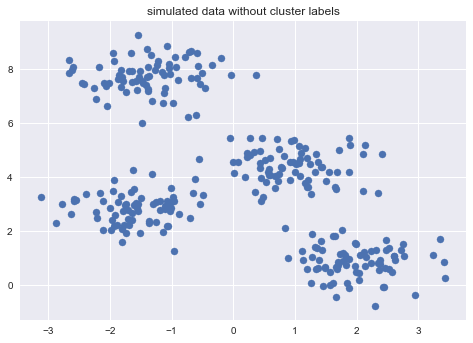

In [5]:
from sklearn.datasets.samples_generator import make_blobs

n_centers = 4
X, y = make_blobs(n_samples=300, centers=n_centers,
                  random_state=0, cluster_std=0.60)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=50)
ax.set_title("simulated data without cluster labels")

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly. But before that, lets visualize the distance matrix.

In [6]:
def Euclidean_distance(x,y):
    '''
    Compute the Euclidean distance between two vectors x and y
    '''
    dist = (np.array(x) - np.array(y))*(np.array(x) - np.array(y))
    return np.sqrt(dist.sum())

In [7]:
n_rows = X.shape[0]
print(n_rows)

X2 = []
for k in range(n_centers):
    X2.append(X[y == k])

X3 = np.array([])
X3 = np.append(X3, X2)
X3 = X3.reshape(300, 2)

300


In [8]:
euclidean_distances = np.zeros((n_rows, n_rows))

In [9]:
# compute the Euclidean distance matrix using the Euclidean_distance function()

for i in range(n_rows):
    print(i, end=' ')
    for j in range(n_rows):
        euclidean_distances[i, j] = Euclidean_distance(X3[i, :], X3[j, :])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

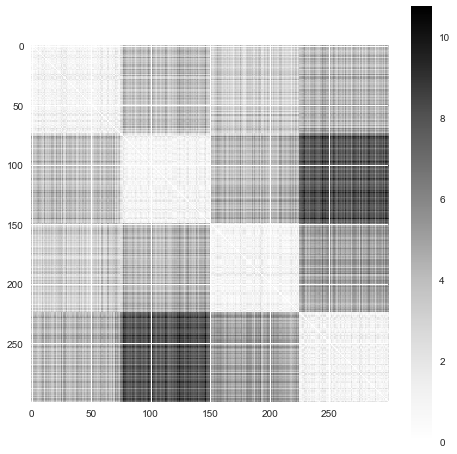

In [10]:
# Visualise this distance matrix

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.imshow(euclidean_distances)
cbar = fig.colorbar(cax)

Now clustering:

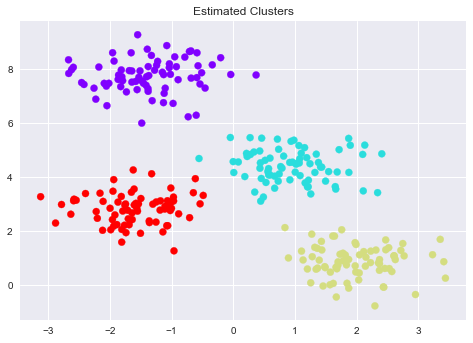

In [11]:
from sklearn.cluster import KMeans

est = KMeans(n_clusters=4)
est.fit(X)

y_kmeans = est.predict(X)
# y_kmeans = est.labels_

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');
ax.set_title('Estimated Clusters')

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## <span style="color:#0b486b">2.1 The K-Means Algorithm: Expectation Maximization</span>


K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

0. Guess some cluster centers
0. Repeat until converged
  0. Assign points to the nearest cluster center
  0. Set the cluster centers to the mean
   
Let's quickly visualize this process. First execute the cell below to import `plot_kmeans_interactive()` which is needed for interactive visualization.

In [12]:
import prac7_utils

C:\Users\ptmin\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<function prac7_utils.plot_kmeans_interactive.<locals>._kmeans_step>

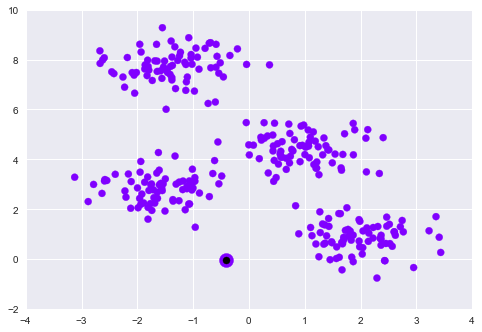

In [13]:
prac7_utils.plot_kmeans_interactive()

This algorithm will (often) converge to the optimal cluster centers.

---
## <span style="color:#0b486b">2.2 Review</span>


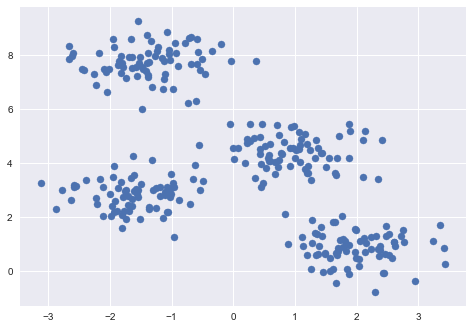

In [14]:
# Simulate the data

n_centers = 4

X, y = make_blobs(n_samples=300, centers=n_centers,
                  random_state=0, cluster_std=0.60)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=50);

In [15]:
est = KMeans(n_clusters=4, init='k-means++', n_init=1, max_iter=100, tol=0.0001, verbose=True)
est.fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 255.592528033
start iteration
done sorting
end inner loop
Iteration 1, inertia 212.005996211
start iteration
done sorting
end inner loop
Iteration 2, inertia 212.005996211
center shift 0.000000e+00 within tolerance 4.686896e-04


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [16]:
est.predict(X)

array([1, 2, 0, 2, 1, 1, 3, 0, 2, 2, 3, 2, 0, 2, 1, 0, 0, 1, 3, 3, 1, 1, 0,
       3, 3, 0, 1, 0, 3, 0, 2, 2, 0, 2, 2, 2, 2, 2, 3, 1, 0, 3, 0, 0, 3, 3,
       2, 3, 2, 1, 3, 1, 2, 1, 1, 3, 2, 3, 2, 1, 2, 0, 2, 3, 3, 3, 2, 1, 2,
       3, 0, 3, 2, 3, 3, 2, 3, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1,
       2, 3, 3, 0, 1, 1, 0, 3, 2, 1, 2, 1, 0, 1, 1, 0, 2, 0, 3, 3, 1, 2, 1,
       0, 2, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 2, 3, 3, 1, 2, 3, 3, 2,
       0, 2, 2, 3, 0, 3, 0, 3, 2, 0, 2, 2, 2, 0, 2, 0, 1, 3, 2, 3, 1, 0, 2,
       0, 0, 1, 0, 3, 3, 0, 1, 0, 0, 2, 1, 0, 3, 2, 1, 1, 0, 3, 1, 0, 3, 3,
       0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 3, 3, 3, 0, 3, 2, 0, 3, 1, 3, 0, 2, 3,
       2, 0, 2, 0, 3, 0, 0, 2, 3, 3, 1, 1, 0, 2, 1, 1, 3, 1, 3, 0, 2, 2, 0,
       0, 2, 0, 1, 3, 0, 1, 3, 2, 3, 1, 0, 1, 2, 2, 2, 2, 3, 3, 2, 0, 3, 1,
       0, 3, 3, 3, 1, 1, 2, 0, 0, 3, 1, 2, 3, 0, 2, 0, 1, 1, 3, 3, 0, 1, 1,
       1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 2, 3, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 2,
       3])

In [17]:
est.labels_

array([1, 2, 0, 2, 1, 1, 3, 0, 2, 2, 3, 2, 0, 2, 1, 0, 0, 1, 3, 3, 1, 1, 0,
       3, 3, 0, 1, 0, 3, 0, 2, 2, 0, 2, 2, 2, 2, 2, 3, 1, 0, 3, 0, 0, 3, 3,
       2, 3, 2, 1, 3, 1, 2, 1, 1, 3, 2, 3, 2, 1, 2, 0, 2, 3, 3, 3, 2, 1, 2,
       3, 0, 3, 2, 3, 3, 2, 3, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1,
       2, 3, 3, 0, 1, 1, 0, 3, 2, 1, 2, 1, 0, 1, 1, 0, 2, 0, 3, 3, 1, 2, 1,
       0, 2, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 2, 3, 3, 1, 2, 3, 3, 2,
       0, 2, 2, 3, 0, 3, 0, 3, 2, 0, 2, 2, 2, 0, 2, 0, 1, 3, 2, 3, 1, 0, 2,
       0, 0, 1, 0, 3, 3, 0, 1, 0, 0, 2, 1, 0, 3, 2, 1, 1, 0, 3, 1, 0, 3, 3,
       0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 3, 3, 3, 0, 3, 2, 0, 3, 1, 3, 0, 2, 3,
       2, 0, 2, 0, 3, 0, 0, 2, 3, 3, 1, 1, 0, 2, 1, 1, 3, 1, 3, 0, 2, 2, 0,
       0, 2, 0, 1, 3, 0, 1, 3, 2, 3, 1, 0, 1, 2, 2, 2, 2, 3, 3, 2, 0, 3, 1,
       0, 3, 3, 3, 1, 1, 2, 0, 0, 3, 1, 2, 3, 0, 2, 0, 1, 1, 3, 3, 0, 1, 1,
       1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 2, 3, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 2,
       3])

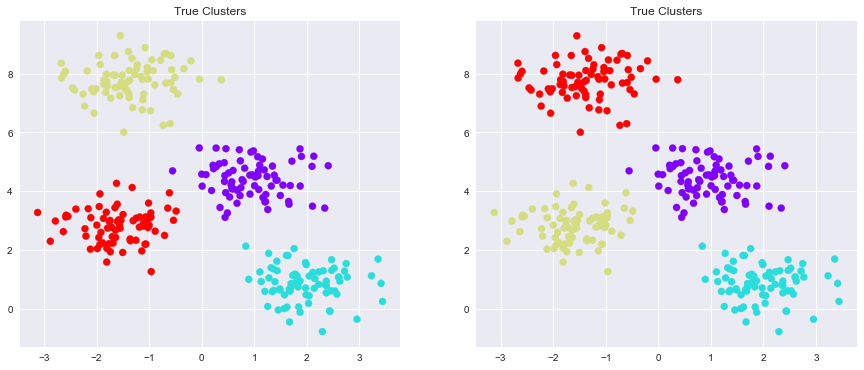

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

ax[0].scatter(X[:, 0], X[:, 1], c=est.labels_, s=50, cmap='rainbow');
ax[0].set_title('True Clusters')

ax[1].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');
ax[1].set_title('True Clusters')

### <span style="color:#0b486b">Note</span>

The cluster labels are not necesarily same as the true labels. This is not important for us. We are only interested in finding the clusters. Remeber KMeans is an unsupervised algorithm. How would it know the cluster labels.

---
## <span style="color:#0b486b">2.4 KMeans for Digits Clustering</span>


For a closer-to-real-world example, let's use a KMean to cluser the digits data provided by Scikit-Learn.

Go to http://scikit-learn.org/stable/datasets/index.html#datasets
to choose one dataset (Section 5.2).

First load up the data:

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()

In this specific example we can look at the data by simply plotting it. Why?

Look at some of the data to see the difference between people's handwriting.

In [20]:
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [21]:
print(digits['DESCR'])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

In [22]:
X = digits['data']
y = digits['target']

In this specific example we can look at the data by simply plotting it. Why?

Look at some of the data to see the difference between people's handwriting.

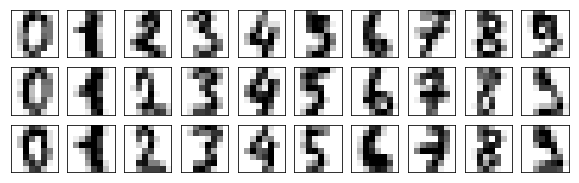

In [23]:
sns.reset_orig()
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(10, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i, :].reshape(8, 8), cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

Setup your KMeans estimator and fit the data:

In [24]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

Visualize the cluster centers and confirm that even though we did not have access to the true labels, the cluster centers are recognizable.

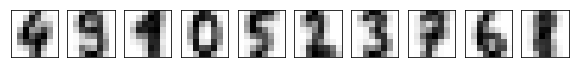

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 1))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(est.cluster_centers_[i].reshape(8, 8), cmap=plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

We mentioned earlier that cluster lables might permute. Investigate and fix it.

In [26]:
j = 1
mask = (clusters == j)
digits.target[mask]

array([5, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 5, 8, 9, 9, 5, 5, 9, 9, 8, 8, 5, 8, 5, 8, 8, 8, 9, 9, 8, 9, 9, 5,
       5, 9, 8, 9, 8, 8, 3, 3, 3, 9, 5, 9, 9, 8, 9, 8, 9, 9, 8, 9, 8, 3, 9,
       3, 5, 9, 3, 5, 9, 5, 5, 9, 9, 5, 3, 3, 3, 9, 9, 5, 3, 3, 3, 9, 5, 9,
       9, 5, 9, 9, 8, 8, 8, 2, 8, 8, 8, 9, 9, 9, 9, 9, 8, 9, 8, 9, 9, 9, 9,
       9, 8, 9, 9, 8, 9, 5, 8, 9, 5, 8, 9, 9, 5, 5, 5, 9, 8, 9, 8, 5, 8, 9,
       5, 9, 5, 8, 9, 8, 9, 5, 8, 5, 9, 5, 9, 8, 9, 8, 9, 8, 9, 9, 9, 8, 9,
       9, 8, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 5, 9, 9, 8, 9, 5, 8, 9, 5, 8, 9, 9, 5,
       5, 5, 9, 8, 9, 8, 5, 9, 5, 9, 8, 9, 8, 5, 9, 5, 8, 9, 8, 9, 8, 9, 9,
       9, 9, 9, 9, 8, 9, 3, 9, 9, 5, 9, 5, 9, 5, 9, 5, 9, 9, 8])

In [27]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [28]:
digits.target[:30]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 6, 7, 8, 9])

In [29]:
labels[:30]

array([0, 8, 8, 3, 4, 9, 6, 7, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2,
       3, 4, 5, 6, 1, 8, 9])

In [30]:
est.labels_

array([3, 9, 9, ..., 9, 1, 1])

<small><i>Some this notebook's material is taken from [Jake Vanderplas](http://www.vanderplas.com) presentation in PyCon 2015.</i></small>